In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, HuberRegressor
import pickle
import itertools
import time
import ot
import os
from scipy.stats import rankdata, spearmanr, kendalltau
import seaborn as sns
from datetime import datetime
# from scipy.signal import savgol_filter
# from scipy.ndimage import gaussian_filter1d
import tv1d

In [19]:
n_group = 6
alpha_arr = np.linspace(-0.5, 0.5, 51)

In [20]:
log_dir = './exec_logs'
cali_dir = './exec_cali'

In [21]:
merged = pd.read_csv('{}/classified_group_{}.csv'.format(log_dir, n_group))
gs = merged['gsector'].unique()
gs = np.sort(gs)

In [22]:
s_corr = np.zeros(11)
k_corr = np.zeros(11)
for k in range(11):
    s_corr[k] = merged[merged['gsector'] == gs[k]][['tdc1', 'sale']].corr(method='spearman').iloc[0, 1]
    k_corr[k] = merged[merged['gsector'] == gs[k]][['tdc1', 'sale']].corr(method='kendall').iloc[0, 1]
    print(s_corr[k], gs[k])

0.7200003472282505 10.0
0.7928956689643197 15.0
0.752101889659705 20.0
0.5151237271620308 25.0
0.7545894894008577 30.0
0.7681547859004926 35.0
0.7453651086449873 40.0
0.645947166842881 45.0
0.750353349037735 50.0
0.870968559496952 55.0
0.5591284801119722 60.0


In [ ]:
merged[(merged['gsector'] == 10) & (merged['year'] == 2021)]

## Constant paths 

In [33]:
bench_zero = True
SIMDATA_PROP = 0.0
sim_n = 10
min_alph_zero = np.zeros((11, sim_n))
for gs_idx in range(11):
    for sim_idx in range(sim_n):
        fdir = 'gs_{}_group_{}_sim_{}_zero_{}_simprop_{}'.format(int(gs[gs_idx]), n_group, sim_idx,
                                                                 bench_zero, SIMDATA_PROP)
        with open('{}/{}/sink_arr.pickle'.format(cali_dir, fdir), 'rb') as fp:
            sink = pickle.load(fp)
#         den_sink = tv1d.denoising_1D_TV(sink, 0.005/2)
        cand = np.where(sink == sink.min())[0]
#         cand = np.where(den_sink == den_sink.min())[0]
        min_id = cand[np.argmin(np.abs(cand-25))]
        min_alph_zero[gs_idx, sim_idx] = alpha_arr[min_id]
#         min_alph_6_zero[gs_idx, sim_idx] = alpha_arr[np.argmin(den_sink)]
#         min_alph_zero[gs_idx, sim_idx] = alpha_arr[np.argsort(sink)[0]].mean()

## Real paths

In [34]:
bench_zero = False
SIMDATA_PROP = 0.0
sim_n = 10
min_alph = np.zeros((11, sim_n))
for gs_idx in range(11):
    for sim_idx in range(sim_n):
        fdir = 'gs_{}_group_{}_sim_{}_zero_{}_simprop_{}'.format(int(gs[gs_idx]), n_group, sim_idx,
                                                                 bench_zero, SIMDATA_PROP)
        with open('{}/{}/sink_arr.pickle'.format(cali_dir, fdir), 'rb') as fp:
            sink = pickle.load(fp)
        den_sink = tv1d.denoising_1D_TV(sink, 0.005/2)
        cand = np.where(sink == sink.min())[0]
#         cand = np.where(den_sink == den_sink.min())[0]
        min_id = cand[np.argmin(np.abs(cand-25))]
#         min_alph_6[gs_idx, sim_idx] = alpha_arr[np.argmin(den_sink)]
        min_alph[gs_idx, sim_idx] = alpha_arr[min_id]

In [ ]:
alpha_arr[25]

## Correlation

In [ ]:
min_alph_zero.std(axis=1).sum()

In [37]:
np.mean(min_alph_zero, axis=1)*30/10

array([ 0.15 , -0.06 ,  0.222,  0.264, -0.054,  0.522, -0.06 ,  0.216,
       -0.096,  0.048,  0.096])

In [35]:
spearmanr(s_corr, np.mean(min_alph_zero, axis=1)*30/10)

SpearmanrResult(correlation=-0.29090909090909095, pvalue=0.38545696969136556)

In [36]:
np.mean(min_alph, axis=1)*30/10

array([ 0.216, -0.06 ,  0.546,  0.3  ,  0.048,  0.534,  0.072,  0.438,
        0.168,  0.276,  0.54 ])

In [38]:
np.mean(min_alph - min_alph_zero, axis=1)*30/10

array([0.066, 0.   , 0.324, 0.036, 0.102, 0.012, 0.132, 0.222, 0.264,
       0.228, 0.444])

In [39]:
spearmanr(s_corr, np.mean(min_alph-min_alph_zero, axis=1))

SpearmanrResult(correlation=-0.21818181818181823, pvalue=0.519248247554982)

In [40]:
kendalltau(k_corr, np.mean(min_alph-min_alph_zero, axis=1))

KendalltauResult(correlation=-0.23636363636363636, pvalue=0.3587114698573032)

In [ ]:
s_corr

In [ ]:
plt.plot(s_corr, np.mean(min_alph-min_alph_zero, axis=1)*3, 'o')

## Figures

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)

firm_num 30


Text(0, 0.5, 'Wasserstein distance (Normalized)')

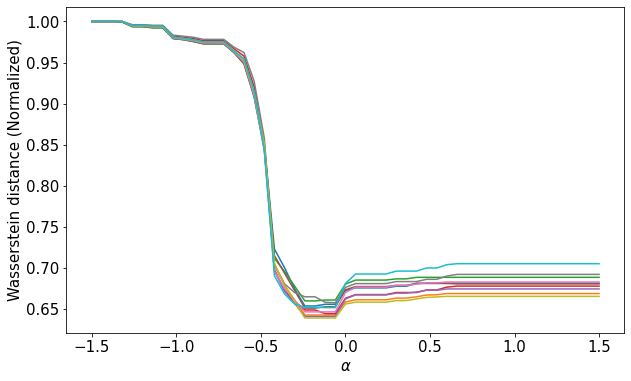

In [32]:
gs_idx = 8
bench_zero = True
SIMDATA_PROP = 0.0
industry = [gs[gs_idx]]
gvkey = merged[merged['gsector'].isin(industry)]['gvkey'].unique()
firm_num = len(gvkey)
print('firm_num', firm_num)
plt.figure(figsize=(10, 6))
for k in range(10):   
    sub_folder = 'gs_{}_group_{}_sim_{}_zero_{}_simprop_{}'.format(int(gs[gs_idx]), n_group, k,
                                                                   bench_zero, SIMDATA_PROP)
    sub_dir = "{}/{}".format(cali_dir, sub_folder)

    with open('{}/sink_arr.pickle'.format(sub_dir), 'rb') as fp:
        sink = pickle.load(fp)
        
#     with open('{}/likelihood.pickle'.format(sub_dir), 'rb') as fp:
#         likeli = pickle.load(fp)        
    
    den_sink = tv1d.denoising_1D_TV(sink, 0.001/2)

#     print('variation', np.sum(np.abs(sink[1:] - sink[:-1])**2)) 
#     print('filtered min alpha', alpha_arr[np.argmin(den_sink)])
#     print('filtered min alpha', alpha_arr[np.argmin(sink_filtered)])
#     print('original min alpha', alpha_arr[np.argsort(sink)[:5]])
#     axs[k].plot(alpha_arr, likeli.sum(axis=1))
#     axs[k].plot(alpha_arr, sink)
    plt.plot(alpha_arr*30/10, den_sink/den_sink[0])   
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel('Wasserstein distance (Normalized)', fontsize=15)

# plt.savefig('gs60_RealEs_real.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [ ]:
str(True)

In [ ]:
SIMDATA_PROP = 0.0
gs_idx = 8
industry = [gs[gs_idx]]
df = []
# gvkey = merged[merged['gsector'].isin(industry)]['gvkey'].unique()
# firm_num = len(gvkey)
# print('firm_num', firm_num)
# sink_sum = np.zeros(51)
for ins in range(sim_n):
    for bench_zero in [True, False]:
        sub_folder = 'gs_{}_group_{}_sim_{}_zero_{}_simprop_{}'.format(int(gs[gs_idx]), n_group, ins,
                                                                       bench_zero, SIMDATA_PROP)
        sub_dir = "{}/{}".format(cali_dir, sub_folder)

        with open('{}/sink_arr.pickle'.format(sub_dir), 'rb') as fp:
            sink = pickle.load(fp)
        df.append(pd.DataFrame({'Q':sink/sink[-1], 'instance': ins*np.ones(51), 
                                'adjusted':[str(bench_zero),]*51, 'step': alpha_arr*30/10}))
Qdf = pd.concat(df)

Qdf = Qdf.reset_index(drop=True)

plt.figure(figsize=(8,6))
palette = sns.color_palette("husl", 2)
g = sns.lineplot(data=Qdf, x='step', y='Q', hue='adjusted', palette=palette) # err_style="bars", errorbar=("se", 2)) 
# estimator=np.median)
# g.set_ylim(99, 110)
# g.set(yscale='log')
# g.axhline(0.0, ls=':')
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel('Q-values', fontsize=16)
g.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.legend(bbox_to_anchor=(1., 1), title='Spreads', fontsize=14, title_fontsize=14)
plt.show()
# plt.savefig('Q_oneside.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [ ]:
diff = np.zeros(11)
for gs_idx in range(11):
    fdir = 'gs_{}_group_{}_zero_{}_simprop_{}'.format(int(gs[gs_idx]), n_group, bench_zero, SIMDATA_PROP)
    with open('{}/{}/obs_path.pickle'.format(log_dir, fdir), 'rb') as fp:
        obs = pickle.load(fp)
    diff[gs_idx] = np.abs(obs[:, ::2] - obs[:, 1::2]).mean()
    print('GS', gs[gs_idx], gs_idx, 'Diff', diff[gs_idx])

In [ ]:
spearmanr(diff, np.median(min_alph_6 - min_alph_6_zero, axis=1))

In [ ]:
# with open('./sim_0_alpha_0/real_path.pickle', 'rb') as fp:
#     real_path = pickle.load(fp)

with open('./normal_simdata_cali_30/gs_10_split_6_sim_0/ot_path_25.pickle', 'rb') as fp:
    ot_path_25 = pickle.load(fp)

with open('./normal_simdata_cali_30/gs_10_split_6_sim_0/ot_path_50.pickle', 'rb') as fp:
    ot_path_50 = pickle.load(fp)

with open('./normal_simdata_cali_30/gs_10_split_6_sim_1/path_prob_25.pickle', 'rb') as fp:
    path_prob_25 = pickle.load(fp)

with open('./normal_simdata_cali_30/gs_10_split_6_sim_1/path_prob_50.pickle', 'rb') as fp:
    path_prob_50 = pickle.load(fp)

In [ ]:
path_prob_25[:20].sum()

In [ ]:
plt.plot(path_prob_50 - path_prob_25)
# plt.plot()

In [ ]:
ot_path_25[:20, :]

In [ ]:
(ot_path_50 - ot_path_25)[:50, :]

In [ ]:
path_num = ot_path_50.shape[0]

In [ ]:
for p in range(50):
    plt.plot(ot_path_25[p, :])

In [ ]:
end_ = 200
print(np.abs(ot_path_25[:end_, ::2] - ot_path_25[:end_, 1::2]).sum()) 
print(np.abs(ot_path_50[:end_, ::2] - ot_path_50[:end_, 1::2]).sum())

In [ ]:
for p in range(path_num):
    plt.plot(ot_path_0[p, :])

In [ ]:
ot_path_0[:50, :] - ot_path_50[:50, :]

In [ ]:
sub_dir = "{}/gs_10_split_7/sim_0_alpha_50".format(log_dir)

with open('{}/value_func.pickle'.format(sub_dir), 'rb') as fp:
    value_func = pickle.load(fp)

In [ ]:
value_func.shape

In [ ]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(16, 12))
ax = sns.heatmap(value_func[1, :, :], xticklabels=np.arange(1, 6),
                 yticklabels=np.arange(1, 6),
                 annot=True, fmt=".1f", annot_kws={"fontsize": 10}, cmap=cmap)
# kurs = "salemat_{}_{}_{}_{}.pdf".format('split', w_split_n, 'gsector', gs[gs_idx]
# plt.savefig(kurs, format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [ ]:
np.unravel_index(np.argsort(ot_init, axis=None), ot_init.shape)

In [ ]:
alpha_arr[[0, 15, 25, 35, 50]]

In [ ]:
0 in [1,2]

In [ ]:
(ot_path_25 - ot_path_50)[:100]

In [ ]:
gs_idx = 0
w_file_name = "wage_trans_{}_{}.pickle".format('gsector', int(gs[gs_idx]))
with open('{}/{}'.format(log_dir, w_file_name), 'rb') as fp:
    wage_trans = pickle.load(fp)

x_shape = wage_trans.shape[0]

cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(12, 10))
ax = sns.heatmap(wage_trans, xticklabels=np.arange(1, x_shape+1),
                 yticklabels=np.arange(1, x_shape+1),
                 annot=True, fmt=".1f", annot_kws={"fontsize": 12}, cmap=cmap)